In [1]:
%matplotlib inline

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow.keras as keras
from tensorflow.keras import layers
# from tensorflow.keras import ops
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import numpy as np
import os
import string
import random
import tensorflow as tf
import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph, IndexedArray
from gensim.models import Word2Vec
import pandas as pd
import matplotlib.pyplot as plt

from stellargraph.mapper import AdjacencyPowerGenerator
from stellargraph.layer import WatchYourStep
from stellargraph import datasets, utils
from tensorflow.keras import callbacks, optimizers, losses, metrics, regularizers, Model

from stellargraph.mapper import KGTripleGenerator
from stellargraph.layer import ComplEx

from IPython.display import HTML

from graph_visualization import GraphVisualization

print("Tensorflow verions:", tf.__version__)
print('Available GPUs:', tf.config.experimental.list_physical_devices('GPU'))

Tensorflow verions: 2.4.0
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.convert_to_tensor([1, 1])], 0
    )
    return tf.tile(mask, mult)


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, "bool")
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [16]:
vocab_size = 50  # Only consider the top 20k words
maxlen = 80  # Max sequence size
batch_size = 128

# The dataset contains each review in a separate text file
# The text files are present in four different folders
# Create a list all files
filenames = []
directories = [
    "gpt-dataset/custom-2.3"
]
for dir in directories:
    for f in os.listdir(dir):
        filenames.append(os.path.join(dir, f))

filenames = filenames[:10000]

print(f"{len(filenames)} files")

# Create a dataset from text files
random.shuffle(filenames)
text_ds = tf_data.TextLineDataset(filenames)
text_ds = text_ds.shuffle(buffer_size=256)
text_ds = text_ds.batch(batch_size)


def custom_standardization(input_string):
    """Remove html line-break tags and handle punctuation"""
    lowercased = tf_strings.lower(input_string)
    stripped_html = tf_strings.regex_replace(lowercased, "<br />", " ")
    return tf_strings.regex_replace(stripped_html, f"([{string.punctuation}])", r" \1")


# Create a vectorization layer and adapt it to the text
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size - 1,
    output_mode="int",
    output_sequence_length=maxlen + 1,
)
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()  # To get words back from token indices

from sklearn.feature_extraction.text import CountVectorizer
def count_occurences(text_ds):

    def preprocess_text(text):
        # Custom text preprocessing
        # For example, you can perform lowercasing, punctuation removal, etc.
        return text.lower()
    
    # Preprocess the text data and convert it to a list
    preprocessed_texts = [preprocess_text(str(text.numpy())) for text in text_ds]
    # Initialize CountVectorizer
    vectorizer = CountVectorizer()
    # Fit CountVectorizer on preprocessed text data and transform it into token counts
    token_counts = vectorizer.fit_transform(preprocessed_texts)
    # Get the vocabulary and token counts
    vocab = vectorizer.get_feature_names_out()
    counts = token_counts.toarray().sum(axis=0)
    # Create a dictionary to store token counts
    token_counts_dict = dict(zip(vocab, counts))

    token_counts_dict = sorted(token_counts_dict.items(), key=lambda item: item[1], reverse=True)
    
    print(token_counts_dict)

# count_occurences(text_ds)

2 files


In [14]:
for text in text_ds:
    print(str(text.numpy()))

[b'It is a musical instrument. It has 6 strings. What is this?'
 b'It is a musical instrument. It has 6 strings. What is this? Guitar.']


In [ ]:
def prepare_lm_inputs_labels(text):
    """
    Shift word sequences by 1 position so that the target for position (i) is
    word at position (i+1). The model will use all words up till position (i)
    to predict the next word.
    """
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]

    # zeros_column = tf.zeros_like(y[:, :1])  # Create a column of zeros with the same shape as the first column of y
    # y = tf.concat([zeros_column, y], axis=1)  # Concatenate the zeros column with y along the column axis
    
    print('x',x)
    print('y',y)
    return x, y

text_ds = text_ds.map(prepare_lm_inputs_labels, num_parallel_calls=tf_data.AUTOTUNE)
text_ds = text_ds.prefetch(tf_data.AUTOTUNE)

In [351]:
graph_embedding_size = 10

def node2vec(G):
        walk_length = 100
        rw = BiasedRandomWalk(G)
        walks = rw.run(
            nodes=G.nodes(),  # root nodes
            length=walk_length,  # maximum length of a random walk
            n=10,  # number of random walks per root node
            p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
            q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
            weighted=False,  # for weighted random walks
            seed=42,  # random seed fixed for reproducibility
        )

        model = Word2Vec(
            walks,  vector_size=graph_embedding_size, window=5, min_count=0, sg=1, workers=1
        )

        return pd.DataFrame([(key, vector) for key,vector in zip(model.wv.index_to_key, model.wv.vectors)], columns=['node', 'embedding'])

def get_graph():
    nodes, edges, edge_types = [], [], []

    for word in conceptnet_data['source'].unique():
        nodes.append(word)

    for word in conceptnet_data['target'].unique():
        nodes.append(word) if word not in nodes else None

    for index, row in conceptnet_data.iterrows():
        edges.append({'source': row['source'], 'target': row['target']})
        edge_types.append(row['label'])

    graph = {'nodes':nodes, 'edges': edges, 'edge_types': edge_types}
    
    edges_ = pd.DataFrame({
            'source': [e['source'] for e in graph['edges']],
            'target': [e['target'] for e in graph['edges']],
            'type': graph['edge_types']
        })
    
    G = StellarGraph(IndexedArray(index=graph['nodes']), edges_, edge_type_column="type")
    
    return graph, G

def get_embeddings(G):
    node_embeddings = complex_embeddings(G, conceptnet_data[['source','label','target']])
        
    return node_embeddings
    
graph, G = get_graph()
node_embeddings = node2vec(G)

tmp = []
for i,word in enumerate(vocab):
    lower_nodes = list(map(lambda k: k.lower(), node_embeddings['node']))
    index = lower_nodes.index(word.lower()) if word.lower() in lower_nodes else -1
    if index != -1:
        tmp.append(node_embeddings.iloc[index][1])
    else:
        tmp.append(np.ones(graph_embedding_size) * -10)

node_embeddings = np.array(tmp).tolist()

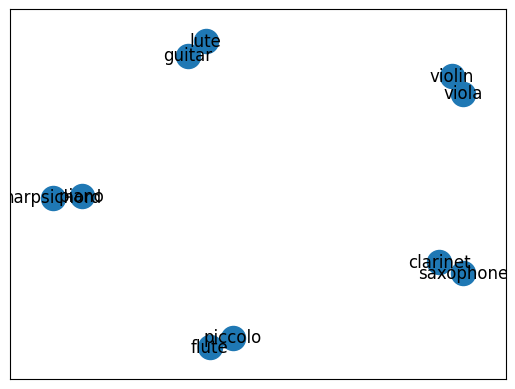

In [354]:
index = 0
vis = GraphVisualization()
for edge in graph['edges'][index:index+30]:
    vis.addEdge(edge['source'], edge['target'])
vis.visualize()

In [357]:
conceptnet_data.loc[conceptnet_data['source'] == 'never']
nodes = conceptnet_data['source'].unique()
index_A = vocab.index('guitar')
index_B = vocab.index('piano')
index_C = vocab.index('lute')
index_D = vocab.index('violin')

from numpy.linalg import norm

def cosine_sim(A,B):
    return np.dot(A,B)/(norm(A)*norm(B))

A,B,C,D = node_embeddings[index_A], node_embeddings[index_B], node_embeddings[index_C], node_embeddings[index_D]
cosine_sim(A,B), cosine_sim(A,C), cosine_sim(B,C), cosine_sim(B,D)
# index_never, index_always, index_little
# A,B,C

(0.17827139169186743,
 0.9923978840216339,
 0.16621150077604804,
 0.344310786941884)

In [358]:
# [(word, emb) for word, emb in zip(vocab, node_embeddings)]

In [360]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]  # Modified line
        positions = tf.range(0, maxlen, 1)  # Modified line
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [361]:
class NodeEmbedding(layers.Layer):
    def __init__(self, node_embed_dim, node_embeddings):
        super().__init__()
        self.node_embeddings = tf.constant(node_embeddings, dtype=tf.float32)
        self.node_embed_dim = node_embed_dim
        self.dense = layers.Dense(node_embed_dim)

    def call(self, x):
         # Reshape x to add a new dimension for embedding
        node_indices = tf.cast(tf.math.round(x), tf.int32)
        node_emb = tf.gather(self.node_embeddings, node_indices)
        node_emb = self.dense(node_emb)  # Apply dense layer to each token embedding
        return node_emb

In [362]:
class TextGenerator(tf.keras.callbacks.Callback):
    """A callback to generate text from a trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for the next token
    3. Sample the next token and add it to the next input

    Arguments:
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from the TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, index_to_word, model = None, top_k=10, print_every=1
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k
        if model: self.model = model
        self.yes_count = 0
        self.no_count = 0
        self.activation_outputs = []
        self.gradients = []

    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = tf.convert_to_tensor(indices, dtype=tf.int32)
        preds = tf.keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = tf.convert_to_tensor(preds, dtype=tf.float32)
  
        # Reshape logits to a matrix
        logits_matrix = tf.reshape(logits, (1, -1))
   
        # Sample from the softmax probabilities
        sampled_index = tf.random.categorical(tf.math.log(preds)[tf.newaxis, :], num_samples=1)

        # Return the sampled index
        return indices[sampled_index[0, 0]]

    def detokenize(self, number):
        return self.index_to_word[number] if number < len(self.index_to_word) else '---'

    def generate_token(self, _start_tokens, tokens_generated):
        pad_len = maxlen - len(_start_tokens)
        sample_index = len(_start_tokens) - 1
        if pad_len < 0:
            x = _start_tokens[:maxlen]
            sample_index = maxlen - 1
        elif pad_len > 0:
            x = _start_tokens + [0] * pad_len
        else:
            x = _start_tokens
        x = np.array([x])
        y = self.model.predict(x, verbose=0)
        sample_token = self.sample_from(y[0][sample_index])
        tokens_generated.append(sample_token)
        _start_tokens.append(sample_token)
        num_tokens_generated = len(tokens_generated)

        return _start_tokens, tokens_generated, num_tokens_generated, y

    def get_generated_text(self, tokens_generated):
        return " ".join(
            [self.detokenize(_) for _ in tokens_generated])
        
    def get_text(self, tokens_generated):
        return " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated])
        
    def on_epoch_end(self, epoch, logs=None):
        _start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        raw_outputs = []
        while num_tokens_generated <= self.max_tokens:
            _start_tokens, tokens_generated, num_tokens_generated, raw_output = self.generate_token(_start_tokens, tokens_generated)
            raw_outputs.append(raw_output)
            
        txt = self.get_text(tokens_generated)
        print(f"generated text:\n{txt}\n")

        self.yes_count += 1 if 'yes' in txt else 0
        self.no_count += 1 if 'no' in txt else 0

        return txt, raw_outputs
    
    def generate(self):
        return self.on_epoc_end(1)

# Tokenize starting prompt
word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index

def callback(start_prompt, model=None, top_k=10):
    start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
    num_tokens_generated = 10
    return TextGenerator(num_tokens_generated, start_tokens, vocab, top_k=top_k) if not model else TextGenerator(num_tokens_generated, start_tokens, vocab, model, top_k)

In [383]:
embed_dim = 128  # Embedding size for each token
num_heads = 2  # Number of attention heads
feed_forward_dim = 128  # Hidden layer size in feed forward network inside transformer

def create_model():
    inputs = layers.Input(shape=(maxlen,), dtype="float32")
    
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
    x = transformer_block(x)

    outputs_1 = layers.Dense(vocab_size, name='text_output')(x)

    node_embedding_layer = NodeEmbedding(embed_dim, node_embeddings)
    x2 = node_embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
    x2 = transformer_block(x2)

    outputs_2 = layers.Dense(vocab_size, name='graph_output')(x2)

    # Concatenate outputs of both branches
    outputs = layers.Average()([outputs_1, outputs_2])

    # outputs = outputs_1

    # Softmax layer
    # softmax_output = layers.Softmax()(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=[outputs])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(
        optimizer=keras.optimizers.Adam(0.001),
        loss=[loss_fn, None],
    )  # No loss and optimization based on word embeddings from transformer block
    return model

In [384]:
model = create_model()
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 80)]         0                                            
__________________________________________________________________________________________________
token_and_position_embedding_13 (None, 80, 128)      16640       input_14[0][0]                   
__________________________________________________________________________________________________
node_embedding_13 (NodeEmbeddin (None, 80, 128)      1408        input_14[0][0]                   
__________________________________________________________________________________________________
transformer_block_26 (Transform (None, 80, 128)      165504      token_and_position_embedding_13[0
___________________________________________________________________________________________

In [385]:
text_gen_callback = callback("guitar is similar to ", model, top_k=2)

In [386]:
history = model.fit(text_ds, verbose=1, epochs=150, callbacks=[text_gen_callback])

Epoch 1/150
1/1 [==============================] - 2s 2s/step - loss: 4.5361
generated text:
guitar is similar to ---    --- clarinet   .  ---

Epoch 2/150
1/1 [==============================] - 0s 31ms/step - loss: 1.8583
generated text:
guitar is similar to           

Epoch 3/150
1/1 [==============================] - 0s 33ms/step - loss: 0.5009
generated text:
guitar is similar to           

Epoch 4/150
1/1 [==============================] - 0s 32ms/step - loss: 0.3422
generated text:
guitar is similar to           

Epoch 5/150
1/1 [==============================] - 0s 29ms/step - loss: 0.3254
generated text:
guitar is similar to           

Epoch 6/150
1/1 [==============================] - 0s 28ms/step - loss: 0.3127
generated text:
guitar is similar to           

Epoch 7/150
1/1 [==============================] - 0s 32ms/step - loss: 0.2824
generated text:
guitar is similar to           

Epoch 8/150
1/1 [==============================] - 0s 33ms/step - loss: 0.2440
generated

In [707]:
text_gen_callback.yes_count, text_gen_callback.no_count

(334, 127)

In [387]:
generator = callback('guitar is similar to ', model, 1)
output = generator.on_epoch_end(0)

generated text:
guitar is similar to lute .         



In [388]:
text_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('text_output').output)
graph_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('graph_output').output)
text = 'guitar is similar to '

In [390]:
generator = callback(text, text_model, 1)
output = generator.on_epoch_end(0)

generated text:
guitar is similar to viola .         



In [404]:
generator = callback(text, graph_model, 1)
output = generator.on_epoch_end(0)

generated text:
guitar is similar to           



In [393]:
generator = text_gen_callback

In [405]:
start_tokens, tokens_generated, num_tokens_generated, raw_output = generator.generate_token([_ for _ in generator.start_tokens], [])
index = len(generator.start_tokens) - 1
raw_output[0][index], tf.argmax(raw_output[0][index]), np.max(raw_output[0][index]), vocab[tf.argmax(raw_output[0][index])], tokens_generated, generator.get_text(tokens_generated)

(array([ 9.0852995 , -2.1351993 ,  3.9451284 ,  4.273572  , -2.2253819 ,
        -0.90423506,  3.4084606 ,  2.3410375 ,  3.4026048 ,  2.561064  ,
         2.1187518 ,  2.1935887 ,  2.0319324 , -0.19848181,  1.6990896 ,
         0.9556687 ,  0.72840387, -2.8963487 , -1.785921  , -4.008631  ,
        -2.9635823 , -2.016038  , -2.280281  , -2.2860997 , -2.390443  ,
        -1.726803  , -2.2424977 , -3.6825337 , -1.8128119 , -3.5176842 ,
        -2.1452487 , -2.1806    , -1.5033053 , -3.7006183 , -3.474283  ,
        -1.7460822 , -2.0837238 , -2.2618098 , -1.797773  , -3.1555114 ,
        -3.4014728 , -3.6229672 , -2.2904289 , -2.5505588 , -2.1384702 ,
        -3.761304  , -2.3024962 , -2.3601925 , -0.77420133, -3.1423674 ],
       dtype=float32),
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 9.0852995,
 '',
 [<tf.Tensor: shape=(), dtype=int32, numpy=0>],
 'guitar is similar to ')

In [291]:
sorted_indexes = np.argsort(raw_output[0][index])[::-1]
sorted = raw_output[0][index][sorted_indexes]
df = pd.DataFrame({'index': sorted_indexes, 'value': sorted})
df, vocab[df.iloc[1]['index'].astype('int')]

(     index      value
 0        0  10.567556
 1       18   4.778914
 2        3   3.885499
 3       26   3.815091
 4       16   3.443519
 ..     ...        ...
 295    243  -7.266131
 296    142  -7.344137
 297    246  -7.488056
 298    237  -7.561741
 299     37  -8.187204
 
 [300 rows x 2 columns],
 'banjo')